# Vision Transformer Transfer Learning on Eurosat Dataset

## 1. Environment Setup

### 1.1 Colab Environment

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

import sys
sys.path.append('/content/gdrive/MyDrive/ml-mavericks')

Mounted at /content/gdrive


### 1.2 Imports

In [2]:
### Torch modules
from torchvision import datasets, models, transforms
from torch.optim import lr_scheduler
from torch.utils.data import random_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, Subset

### For TPU support
# import torch_xla
# import torch_xla.core.xla_model as xm

### Other DS modules
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

### Other modules
from tqdm import tqdm
from datetime import datetime
import os 
import time
import copy
import h5py

from utils.utils import EurosatPreloadedDataset, EurosatPreloadedTestset, plot_confusion_matrix, plot_learning_curve

### 1.3 Global Variables

The path variables may need to be adjusted depending on your system.



In [3]:
H5_TRAINING_PATH = "/content/gdrive/MyDrive/ml-mavericks/data/trainingset_RGB_NDVI.h5"
H5_TEST_PATH = "/content/gdrive/MyDrive/ml-mavericks/data/testset_RGB_NDVI.h5"
MODEL_OUTPUT = "/content/gdrive/MyDrive/ml-mavericks/models"
VISUALIZATION_OUTPUT = "/content/gdrive/MyDrive/ml-mavericks/visualisation"
SUBMISSION_OUTPUT = "/content/gdrive/MyDrive/ml-mavericks/submissions"

In [4]:
## Initialization of CLASS_LABELS: list of the 10 land cover types covered in Eurosat 
CLASS_LABELS = ["AnnualCrop", "Forest", "HerbaceousVegetation", "Highway", "Industrial", "Pasture", 
                "Permanent Crop", "Residential", "River", "SeaLake"]

## Initialization of ID2LABEL: dictionary that maps numerical IDs to their corresponding land cover types
ID2LABEL = {0: "AnnualCrop", 1: "Forest", 2: "HerbaceousVegetation", 3: "Highway", 4: "Industrial", 
            5: "Pasture", 6: "PermanentCrop", 7: "Residential", 8: "River", 9: "SeaLake"}

In [5]:
## Initialization of Torch device to use CUDA for GPU acceleration for faster computation
DEVICE = torch.device("cuda")

## 2. Data Setup

### 2.1 Train Val Split


As we use different data augmentations for the training and validation set, we have to split our data before loading it. This will enable us to have two different class instances that load the specific indices for train resp. validation data.

In [6]:
TRAIN_VAL_SPLIT_RATIO = 0.12

In [7]:
# Load the indices to perform the train test split
with h5py.File(H5_TRAINING_PATH, "r") as f:
    X = list(f['labels'])
    # create a list with all indices of X
    X_indices = [i for i in range(len(X))]

We split the eurosat data set into training and validation set to assess model performance, select the best model and hyperparameters, prevent overfitting, and estimate the model's generalization ability on unseen data.

In [8]:
# Test split (into train and validation indices)
X_train_indices, X_val_indices = train_test_split(X_indices, shuffle=True, random_state=42, test_size=TRAIN_VAL_SPLIT_RATIO)

In [9]:
dataset_sizes = {"train": len(X_train_indices), "val": len(X_val_indices)}

Sorting the indices is necessary to load the images later on:

In [10]:
X_train_indices.sort()
X_val_indices.sort()

### 2.2 Data Augmentations

We apply different transformations on training, validation and test set (random transformations are only performed on the training set).

In [14]:
transform_train = transforms.Compose([

        # transform from array to tensor
        transforms.ToTensor(),

        # enlarge the images by bilinear interpolation                       
        transforms.Resize([204,204], antialias=None),                            

        # rotate the picture by the degree input
        transforms.RandomRotation(5),

        # filp by vertical
        # transforms.RandomVerticalFlip(0.5),

        # pad the edges by 10 pixels
        transforms.RandomCrop(224, padding = 10),
        
        # normalize
        transforms.Normalize([0.389, 0.411, 0.385], [0.264, 0.259, 0.259])

    ])

transform_val = transforms.Compose([

        # transform from array to tensor
        transforms.ToTensor(),

        # enlarge the images by bilinear interpolation
        transforms.Resize([204,204], antialias=None),
        
        # cut the image from the center
        transforms.CenterCrop(224),

        # normalize
        transforms.Normalize([0.389, 0.411, 0.386], [0.263, 0.255, 0.255])
        ])


transform_test = transforms.Compose([

        # transform from array to tensor
        transforms.ToTensor(),

        # enlarge the images by bilinear interpolation
        transforms.Resize([204,204], antialias=None),
        
        # cut the image from the center
        transforms.CenterCrop(224),

        # normalize
        transforms.Normalize([0.346, 0.387, 0.348], [0.261, 0.255, 0.259])
        ])

### 2.3 Data Loading

We create a dataloader with our custom data sets to iterate through its samples.
Validation and Training set share the same data set class, but load different images (through the indices given).

In [15]:
BATCH_SIZE = 32

In [13]:
trainset = EurosatPreloadedDataset(root_dir=H5_TRAINING_PATH, transform=transform_train, classes=CLASS_LABELS, indices=X_train_indices)
valset = EurosatPreloadedDataset(root_dir=H5_TRAINING_PATH, transform=transform_val, classes=CLASS_LABELS, indices=X_val_indices)

In [16]:
testset = EurosatPreloadedTestset(root_dir=H5_TEST_PATH, transform=transform_test)

In [17]:
## Loading data into DataLoader
training_dl = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_dl = torch.utils.data.DataLoader(valset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

## 3. Model Setup

### 3.1 Model initialization

For the model, we opted for the vit_b_16 which showed one of the best performances of pretrained PyTorch vision transformers for a smaller image size of 224x224 (see https://pytorch.org/vision/stable/models.html).

In [18]:
## Downloading 
# Memory-efficient model: torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', pretrained=True)
pretrained_model = models.get_model('vit_b_16', weights='DEFAULT', image_size=224)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:04<00:00, 71.8MB/s]


In [ ]:
## Freeze all layers except the final layer - didnt show better performance (needs additional layers)
## for param in model_ft.parameters():
##    param.requires_grad = False

In order to use the pretrained model we had to adjust the model head to fit the number of classes.

In [19]:
num_ftrs = pretrained_model.heads.head.in_features
pretrained_model.heads.head = nn.Linear(num_ftrs, len(CLASS_LABELS))

In [20]:
## In case you would like to continue from a checkpoint
# checkpoint = torch.load('/content/gdrive/MyDrive/ml-mavericks/models/vitb16_epochs4_20230515_115941_best_model.pth')  # load the saved state dictionary
# pretrained_model.load_state_dict(checkpoint)  # assign the state dictionary to the model

In [21]:
model_ft = pretrained_model # we directly use the pretrained model - no dropout in this case

model_ft = model_ft.to(DEVICE)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

## 4. Training & Evaluation

During training we track the train and validation accuracy: We store the model with best validation accuracy over all epochs.

### 4.1 Model Training

In [22]:
## Setting function for model training
train_losses = []
val_losses = []

train_accs = []
val_accs = []

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            
            if phase == 'train':
                dataloaders = training_dl
            else: 
                dataloaders = val_dl

            for inputs, labels in tqdm(dataloaders):
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            if phase == 'train':
              train_losses.append(epoch_loss)
              train_accs.append(epoch_acc)
            else:
              val_losses.append(epoch_loss)
              val_accs.append(epoch_acc)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)

 Let's define the number of epochs:

In [23]:
EPOCHS = 4

And start the training:

In [24]:
## Running time roughly 3 min per epoch (with A100 GPU & 2 workers)
train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=EPOCHS)

Epoch 1/4
----------


100%|██████████| 743/743 [02:57<00:00,  4.20it/s]


train Loss: 0.8169 Acc: 0.8102


100%|██████████| 102/102 [00:08<00:00, 12.60it/s]


val Loss: 0.2701 Acc: 0.9457

Epoch 2/4
----------


100%|██████████| 743/743 [02:56<00:00,  4.22it/s]


train Loss: 0.1905 Acc: 0.9561


100%|██████████| 102/102 [00:08<00:00, 12.61it/s]


val Loss: 0.1493 Acc: 0.9608

Epoch 3/4
----------


100%|██████████| 743/743 [02:56<00:00,  4.22it/s]


train Loss: 0.1188 Acc: 0.9694


100%|██████████| 102/102 [00:08<00:00, 12.57it/s]


val Loss: 0.1102 Acc: 0.9688

Epoch 4/4
----------


100%|██████████| 743/743 [02:56<00:00,  4.22it/s]


train Loss: 0.0919 Acc: 0.9751


100%|██████████| 102/102 [00:08<00:00, 12.61it/s]

val Loss: 0.0933 Acc: 0.9722

Training complete in 12m 18s
Best val Acc: 0.972222


### 4.2 Visualisations

In [25]:
formatted_now = datetime.now().strftime("%Y%m%d_%H%M%S")

We plot a confusion matrix to show the misclassification for all classes.

100%|██████████| 3240/3240 [00:28<00:00, 112.98it/s]


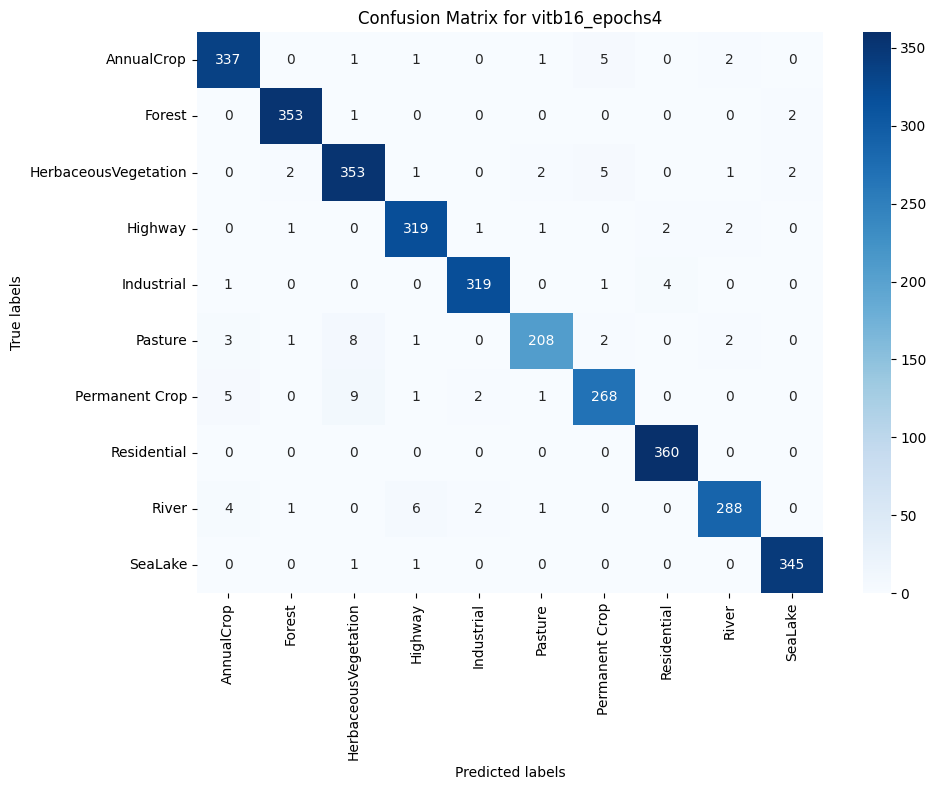

In [26]:
plot_confusion_matrix(model_ft, valset, CLASS_LABELS, "vitb16_epochs4", os.path.join(VISUALIZATION_OUTPUT, f'confusion_matrix_vitb16_epochs4_{formatted_now}.jpg'), DEVICE)

Also interesting might be the training and validation loss over the epochs.

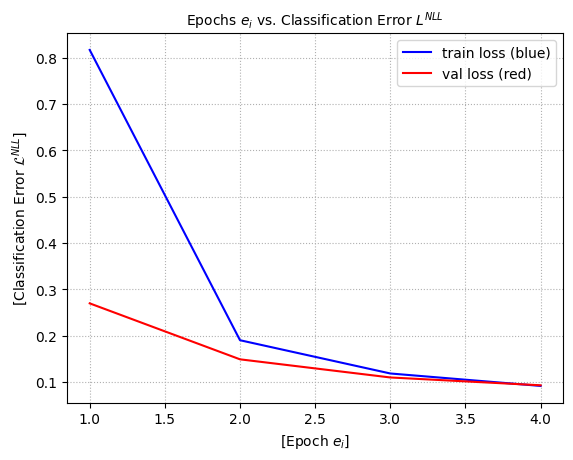

In [27]:
## Plots the training and validation loss over time
plot_learning_curve(train_losses, val_losses, f"vitb16_epochs{EPOCHS}", formatted_now, VISUALIZATION_OUTPUT)

### 4.3 Saving Model

To use the model later as checkpoint, we store it in a PTH-file.

In [28]:
## Saving the model
torch.save(model_ft.state_dict(), os.path.join(MODEL_OUTPUT, f'vitb16_epochs4_custom_normalization_{formatted_now}.pth'))

## 5. Inference

Now it is time to make some predictions on the test set.

### 5.1 Inference on Test Data

In [29]:
predicted_results = []

for i in tqdm(range(len(testset.ids))):
    model = model_ft.eval()
    sample, id = testset.__getitem__(i)
    sample = sample.to(DEVICE)
    
    with torch.no_grad():
        output = model(sample.unsqueeze(0))
        _, predicted = torch.max(output.data, 1)
    
    predicted_group = ID2LABEL[predicted.item()]
    testid = int(id)
    
    predicted_results.append((testid, predicted_group))

100%|██████████| 4232/4232 [00:40<00:00, 104.97it/s]


### 5.2 Submission File

Finally we submit the predictions in form of CSV file.

In [31]:
submission = pd.DataFrame(predicted_results, columns=["test_id", "label"])
submission = submission.sort_values("test_id")
submission.to_csv(os.path.join(SUBMISSION_OUTPUT, f"submission_vitb16_epochs{EPOCHS}_{formatted_now}.csv"), index=False)